# Project: Teaching an LLM to Reason

In this project, you will teach an LLM to use step-by-step reasoning to answer the question: "How many X's are there in the word Y?"

Counting letters in a word is a surprisingly complex task for an LLM. Just as human beings would not be able to answer such a question for longer words without breaking down the word into its individual letters and then counting them, LLMs cannot be similarly expected to be able to respond without using smaller reasoning steps.

For example, to count the number of o's in the word room, one could use the following reasoning:

```
Question: How many of the letter "o" are there in the word "room"
Answer: 2
Response:

<reasoning>
Letter-by-letter spelling:
1. r - 0 o's so far
2. o - 1 o's so far
3. o - 2 o's so far
4. m - 2 o's so far

The letter "o" appears 2 times in the word "room".
</reasoning>
<answer>
2
</answer>
```

In this project we will use the reinforcement learning method GRPO (Group Relative Policy Optimization, of DeepSeek fame) to take a large language model that has been fine-tuned for following instructions and teach it how to break a word down into its letters and then count the requested letter.

We will complete the following steps:

* Set up the notebook
* Create a letter-counting dataset
* Create the reward functions
* Train the model
* View the results

NOTE: This notebook will have you focus on several important aspects of training a GPRO model using LoRA:

1. Configuring LoRA adapters for parameter-efficient fine tuning
2. Selecting reward functions that help the model efficiently find its way to the correct answer (also called reward shaping)
3. Finding hyperparameters that help the model increase the rewards earned more quickly and reliably
4. Learning how to start with smaller experiments and to work your way up to longer experiments.

## Set up the notebook

We'll install dependencies needed for the project, namely `unsloth` and `vllm`, which are useful for fine-tuning LLMs with even just 15GB of VRAM.

In [ ]:
!pip install unsloth==2025.9.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of trl to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of trl to determine which version is compatible with other requirements. This could take a while.
  Using cached msgspec-0.20.0-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
INFO: pip is looking at multiple versions of torchvision to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.6/314.6 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 126.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install vllm

  Using cached vllm-0.13.0-cp38-abi3-manylinux_2_31_x86_64.whl.metadata (18 kB)
  Using cached blake3-1.0.8-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.6 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.8 MB/s eta 0:00:00
  Using cached prometheus_fastapi_instrumentator-7.1.0-py3-none-any.whl.metadata (13 kB)
  Using cached lm_format_enforcer-0.11.3-py3-none-any.whl.metadata (17 kB)
  Using cached llguidance-1.3.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
  Using cached outlines_core-0.2.11-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached diskcache-5.6.3-py3-none-any.whl.metadata (20 kB)
  Using cached lark-1.2.2-py3-none-any.whl.metadata (1.8 kB)
  Using cached xgrammar-0.1.27-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
  Using cached partial_json_parser-0.2.1.1.post7-py3-none-any.whl.metadata (6.1 kB)
  Using cached gguf-0.17.1-py3-non

time: 2min 55s (started: 2025-12-22 18:27:07 +00:00)


In [ ]:
!pip install --upgrade unsloth unsloth_zoo vllm

  Using cached unsloth-2025.12.8-py3-none-any.whl.metadata (65 kB)
INFO: pip is looking at multiple versions of xformers to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.1/376.1 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 MB 7.0 MB/s eta 0:00:00
  Attempting uninstall: xformers
    Found existing installation: xformers 0.0.33.post2
    Uninstalling xformers-0.0.33.post2:
      Successfully uninstalled xformers-0.0.33.post2
  Attempting uninstall: unsloth
    Found existing installation: unsloth 2025.9.7
    Uninstalling unsloth-2025.9.7:
      Successfully uninstalled unsloth-2025.9.7


time: 23.9 s (started: 2025-12-22 18:38:04 +00:00)


In [ ]:
!pip install --upgrade pydantic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.6/463.6 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.6 MB/s eta 0:00:00
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.41.4
    Uninstalling pydantic_core-2.41.4:
      Successfully uninstalled pydantic_core-2.41.4
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.12.3
    Uninstalling pydantic-2.12.3:
      Successfully uninstalled pydantic-2.12.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 5.50.0 requires pydantic<=2.12.3,>=2.0, but you have pydantic 2.12.5 which is incompatible.


time: 19.2 s (started: 2025-12-22 18:41:52 +00:00)


In [ ]:
# Load ipython-autotime to see how long each cell take to run
# No changes needed in this cell

!pip install -q ipython-autotime
%load_ext autotime

time: 371 µs (started: 2025-12-22 18:42:46 +00:00)


In [ ]:
# Verify we have enough GPU memory to run this project (at least 15360MiB)
# No changes needed in this cell

!nvidia-smi

Mon Dec 22 18:42:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Load the `Qwen 2.5 3B Instruct`, and set parameters for the project
# The first time unsloth is imported, it will do its magic and patch the modules
# it works with. This may 2-5 minutes.

import unsloth

from unsloth import FastLanguageModel
import torch

max_seq_length = 384  # Increase if you get errors about the sequence length

# Set the LoRA rank to an appropriate value
# Read about setting LoRA rank:
# https://docs.unsloth.ai/get-started/fine-tuning-llms-guide/lora-hyperparameters-guide
# Setting lora_rank to 64 provides a good balance between model capacity and memory efficiency.
# A higher rank allows the model to learn more complex patterns but uses more memory.
# For this task (letter counting with reasoning), 64 is sufficient for good performance.
lora_rank = 64

# Load the Instruct model in 4-bit mode
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen2.5-3B-Instruct",
    max_seq_length=max_seq_length,
    load_in_4bit=True,  # We'll use quantization!
    fast_inference=False,  # This uses vllm for faster inference
    max_lora_rank=lora_rank,
    disable_log_stats = True,
    gpu_memory_utilization=0.5,  # You can reduce this if you get an memory error
)

model = FastLanguageModel.get_peft_model(
    model,
    r=lora_rank,
    target_modules=[
        # Read about choosing adapters for LoRA:
        # https://docs.unsloth.ai/get-started/fine-tuning-llms-guide/lora-hyperparameters-guide
        # Targeting all key linear layers in attention and MLP blocks for comprehensive adaptation.
        # This ensures the model can learn the reasoning task effectively across all transformer components.
        "q_proj",    # Query projection in attention
        "k_proj",    # Key projection in attention
        "v_proj",    # Value projection in attention
        "o_proj",    # Output projection in attention
        "gate_proj", # Gate projection in MLP
        "up_proj",   # Up projection in MLP
        "down_proj", # Down projection in MLP
    ],
    lora_alpha=lora_rank,
    use_gradient_checkpointing="unsloth",  # Unsloth enables longer contexts
    # See: https://github.com/unslothai/unsloth
)

==((====))==  Unsloth 2025.12.8: Fast Qwen2 patching. Transformers: 4.57.3. vLLM: 0.13.0.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.36G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Unsloth 2025.12.8 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


time: 1min 10s (started: 2025-12-22 18:45:12 +00:00)


## Try Prompt Engineering to Count Letters

Let's work on the system prompt a little to see if we can get the model to count the number of the letter `g` in `engage`.


Here you must:
* Write clear instructions
* Break the problem down into steps (Chain-of-Thought prompting)
* Provide at least one example for the model to follow (Few-shot prompting)

In [ ]:
# First, let's see what happens when we have a blank system prompt
# No changes needed in this cell
SYSTEM_PROMPT = """"""
USER_PROMPT = 'How many of the letter "g" are there in the word "engage"'

# Convert the chat messages to a single string so the model can complete it
text_for_completion = tokenizer.apply_chat_template(
    conversation=[
        {"role": "system", "content": SYSTEM_PROMPT},
        {
            "role": "user",
            "content": USER_PROMPT,
        },
    ],
    tokenize=False,
    add_generation_prompt=True,
)

from vllm import SamplingParams

# Set the LLM sampling parameters
sampling_params = SamplingParams(
    temperature=0.8,
    top_p=0.95,
    max_tokens=2048,
)

# Generate the text completion

inputs = tokenizer([text_for_completion], return_tensors="pt").to("cuda")

output = model.generate(
    **inputs,
    max_new_tokens=2048,
    temperature=0.8,
    top_p=0.95,
    use_cache=True,
)
# Decode the output
generated_text = tokenizer.batch_decode(output)[0]
# To remove the prompt and keep only the response:
response = generated_text.split("<|begin_of_text|>")[-1].split("assistant\n")[-1]


# Print the text input for the model and the model's output
print("=== TEXT FOR COMPLETION ===")
print(text_for_completion)

# 1. Generate as you did (already creates 'output' tensor)
# 2. Decode the tensor into text
# skip_special_tokens=True removes <|im_start|>, <|im_end|>, etc.
decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)

# 3. Extract only the assistant's part
# The prompt is included in 'output', so we split it to get just the reply
response = decoded_output.split("assistant")[-1].strip()

print("=== GENERATED OUTPUT ===")
print(response)

=== TEXT FOR COMPLETION ===
<|im_start|>system
<|im_end|>
<|im_start|>user
How many of the letter "g" are there in the word "engage"<|im_end|>
<|im_start|>assistant

=== GENERATED OUTPUT ===
There is 1 letter "g" in the word "engage".
time: 3.17 s (started: 2025-12-22 18:54:15 +00:00)


Without any prompting the model will generate an output such as this:

```
=== GENERATED OUTPUT ===
There is one letter "g" in the word "engage".
```

Now let's work on the system prompt to help the model break this problem down into steps, which might help it get the right answer (2 `g`'s in `engage`)

In [ ]:
# Let's work on a new system prompt that will help the model break this problem
# down into steps, for example, using "letter-by-letter" spelling.

# Use a CoT prompt with at least one example
SYSTEM_PROMPT = """You are an assistant that counts letters in words. You should think step-by-step and use letter-by-letter spelling.

Follow this format:

<reasoning>
Letter-by-letter spelling:
1. [letter] - [count] [target letter]'s so far
2. [letter] - [count] [target letter]'s so far
...

The letter "[target letter]" appears [count] times in the word "[word]".
</reasoning>
<answer>
[count]
</answer>

Example:
Question: How many of the letter "o" are there in the word "room"
<reasoning>
Letter-by-letter spelling:
1. r - 0 o's so far
2. o - 1 o's so far
3. o - 2 o's so far
4. m - 2 o's so far

The letter "o" appears 2 times in the word "room".
</reasoning>
<answer>
2
</answer>

Now answer the question using the same format.
"""


USER_PROMPT = 'How many of the letter "g" are there in the word "engage"'

# Convert the chat messages to a single string so the model can complete it
text_for_completion = tokenizer.apply_chat_template(
    conversation=[
        {"role": "system", "content": SYSTEM_PROMPT},
        {
            "role": "user",
            "content": USER_PROMPT,
        },
    ],
    tokenize=False,
    add_generation_prompt=True,
)

from vllm import SamplingParams

# Set the LLM sampling parameters
sampling_params = SamplingParams(
    temperature=0.8,
    top_p=0.95,
    max_tokens=2048,
)

# Generate the text completion
inputs = tokenizer([text_for_completion], return_tensors="pt").to("cuda")

output = model.generate(
    **inputs,
    max_new_tokens=2048,
    temperature=0.8,
    top_p=0.95,
    use_cache=True,
)

# Print the text input for the model and the model's output
print("=== TEXT FOR COMPLETION ===")
print(text_for_completion)

# 1. Generate as you did (already creates 'output' tensor)
# 2. Decode the tensor into text
# skip_special_tokens=True removes <|im_start|>, <|im_end|>, etc.
decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)

# 3. Extract only the assistant's part
# The prompt is included in 'output', so we split it to get just the reply
response = decoded_output.split("assistant")[-1].strip()

print("=== GENERATED OUTPUT ===")
print(response)


=== TEXT FOR COMPLETION ===
<|im_start|>system
You are an assistant that counts letters in words. You should think step-by-step and use letter-by-letter spelling.

Follow this format:

<reasoning>
Letter-by-letter spelling:
1. [letter] - [count] [target letter]'s so far
2. [letter] - [count] [target letter]'s so far
...

The letter "[target letter]" appears [count] times in the word "[word]".
</reasoning>
<answer>
[count]
</answer>

Example:
Question: How many of the letter "o" are there in the word "room"
<reasoning>
Letter-by-letter spelling:
1. r - 0 o's so far
2. o - 1 o's so far
3. o - 2 o's so far
4. m - 2 o's so far

The letter "o" appears 2 times in the word "room".
</reasoning>
<answer>
2
</answer>

Now answer the question using the same format.
<|im_end|>
<|im_start|>user
How many of the letter "g" are there in the word "engage"<|im_end|>
<|im_start|>assistant

=== GENERATED OUTPUT ===
<reasoning>
Letter-by-letter spelling:
1. a - 0 g's so far
2. n - 0 g's so far
3. g - 1 g's

Did your new prompt get the right answer? Did the model follow all of your instructions?

Maybe yes, maybe no. Either way, we'll want the model to reliably complete this challenge. So let's use GRPO to help it!

## Create a letter-counting dataset

To train a model, we'll first need to create a dataset. We'll use the HuggingFace `datasets` package.

In [ ]:
# Create a list of words of different lengths
# No changes are needed in this cell.

ALL_WORDS = [
    "idea",
    "glow",
    "rust",
    "maze",
    "echo",
    "wisp",
    "veto",
    "lush",
    "gaze",
    "knit",
    "fume",
    "plow",
    "void",
    "oath",
    "grim",
    "crisp",
    "lunar",
    "fable",
    "quest",
    "verge",
    "brawn",
    "elude",
    "aisle",
    "ember",
    "crave",
    "ivory",
    "mirth",
    "knack",
    "wryly",
    "onset",
    "mosaic",
    "velvet",
    "sphinx",
    "radius",
    "summit",
    "banner",
    "cipher",
    "glisten",
    "mantle",
    "scarab",
    "expose",
    "fathom",
    "tavern",
    "fusion",
    "relish",
    "lantern",
    "enchant",
    "torrent",
    "capture",
    "orchard",
    "eclipse",
    "frescos",
    "triumph",
    "absolve",
    "gossipy",
    "prelude",
    "whistle",
    "resolve",
    "zealous",
    "mirage",
    "aperture",
    "sapphire",
]

print(len(ALL_WORDS))

ALL_WORDS[:10]

62


['idea',
 'glow',
 'rust',
 'maze',
 'echo',
 'wisp',
 'veto',
 'lush',
 'gaze',
 'knit']

time: 3.82 ms (started: 2025-12-22 18:56:50 +00:00)


In [ ]:
# Create the dataset as a Hugging Face Dataset using Dataset.from_generator
# No changes needed in this cell

from datasets import Dataset
import random


# Go through the letters from the words (as well as letters not in the words),
# and create a labelled dataset with all the different combinations.
# For example for the word gaze:
# 1. How many i's are in idea? <-- count should be 1
# 2. How many d's are in idea? <-- count should be 1
# 3. How many e's are in idea? <-- count should be 1
# 4. How many a's are in idea? <-- count should be 1
# 5. How many b's are in idea? <-- a letter not in word (count should be zero)
def generate_records():
    for word in ALL_WORDS:
        for letter in sorted(set(word)):
            yield {"words": word, "letters": letter, "counts": word.count(letter)}

        # pick random letters not in the word
        num_letters_not_in_word_left = int(len(word) // 7 + 1)

        random.seed(hash(word))

        all_letters = list("abcdefghijklmnopqrstuvwxyz")

        random.shuffle(all_letters)
        for letter in all_letters:
            if letter not in word:
                yield {"words": word, "letters": letter, "counts": 0}
                num_letters_not_in_word_left -= 1
            if num_letters_not_in_word_left == 0:
                break


ds = Dataset.from_generator(generate_records)

# Show the first item
ds[0]

Generating train split: 0 examples [00:00, ? examples/s]

{'words': 'idea', 'letters': 'a', 'counts': 1}

time: 206 ms (started: 2025-12-22 18:57:12 +00:00)


In [ ]:
# Add the entire prompt (system + user) and the answer to the dataset
# We'll use a prompt that spells out the word letter-by-letter
# No changes needed in this cell

import re
from datasets import load_dataset, Dataset

# Simple CoT prompt (zero-shot)
SYSTEM_PROMPT = """
Respond in the following format:
<reasoning>
Counting the number of [letter_to_count]'s in the word [word]
1. [first letter] - [count of requested letter so far] so far
2. [second letter] - [count of requested letter so far] so far
...
</reasoning>
<answer>
[number]
</answer>
"""

ds = ds.map(
    lambda x: {  # type: ignore
        "prompt": [
            {"role": "system", "content": SYSTEM_PROMPT},
            {
                "role": "user",
                "content": 'How many of the letter "{}" are there in the word "{}"'.format(
                    x["letters"], x["words"]
                ),
            },
        ],
    }
)

ds[0]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

{'words': 'idea',
 'letters': 'a',
 'counts': 1,
 'prompt': [{'content': "\nRespond in the following format:\n<reasoning>\nCounting the number of [letter_to_count]'s in the word [word]\n1. [first letter] - [count of requested letter so far] so far\n2. [second letter] - [count of requested letter so far] so far\n...\n</reasoning>\n<answer>\n[number]\n</answer>\n",
   'role': 'system'},
  {'content': 'How many of the letter "a" are there in the word "idea"',
   'role': 'user'}]}

time: 65.3 ms (started: 2025-12-22 18:57:29 +00:00)


In [ ]:
# Let's see how well the model runs out-of-the-box
# No changes needed in this cell

text = tokenizer.apply_chat_template(
    ds[0]["prompt"], tokenize=False, add_generation_prompt=True
)

from vllm import SamplingParams

sampling_params = SamplingParams(
    temperature=0.8,
    top_p=0.95,
    max_tokens=1024,
)

output = model.generate(
    **inputs,
    max_new_tokens=2048,
    temperature=0.8,
    top_p=0.95,
    use_cache=True,
)

decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)
response = decoded_output.split("assistant")[-1].strip()

print("=== GENERATED OUTPUT ===")
print(response)

=== GENERATED OUTPUT ===
<reasoning>
Letter-by-letter spelling:
1. a - 0 g's so far
2. n - 0 g's so far
3. g - 1 g's so far
4. e - 1 g's so far
5. n - 1 g's so far
6. g - 2 g's so far
7. e - 2 g's so far

The letter "g" appears 2 times in the word "engage".
</reasoning>
<answer>
2
</answer>
time: 9.43 s (started: 2025-12-22 18:59:40 +00:00)


## Create Reward Functions

One goal of creating reward functions is to guide the model toward behaviors that help it reach its goal (counting the occurrences of a letter within a word) more easily. Since there is more than one way to carry out any step-by-step task (e.g. whether or not you use bullet points to separate your steps), there's a bit of judgement involved in choosing what behaviors to reward, i.e. how do we provide partial credit or "shape" our rewards?

In this case we will encourage the model to (whether or not this structure is best):
* use numbers for bullet points when spelling out the word
* to spell the word correctly
* to count the requested letter correctly
* to use the requested reasoning format
* to get the final answer correct.


### Numbering reward function

In [ ]:
# Let's work on a function that the numbering in the bullet points is correct
# When using GRPO, we lean on reward functions that are relatively easy to
# compute, thus removing the need to have a second large model just for
# evaluation.
# In this case, we'll use regular expressions quite a bit.


def extract_letter_numbering(response):
    """Extract the numbers at the beginning of the line

    Example:
    1. g - 1 so far
    2. o - 1 so far
    3. a - 2 so far
    4. a - 2 so far
    5. l - 2 so far
    returns [1, 2, 3, 4, 5]
    """
    import re

    # We use a regular expression to find lines of the form:
    # '\n[number]. [letter]'
    pattern = r"\n(\d+). [a-z]"

    # Use `re` to find all matches of the pattern in the response
    matches = re.findall(pattern, response, re.IGNORECASE)
    if matches:
        return [int(m) for m in matches]
    return []


assert extract_letter_numbering(
    """
1. g - 1 so far
2. o - 1 so far
3. a - 2 so far
4. a - 2 so far
5. l - 2 so far
"""
) == [1, 2, 3, 4, 5]


def numbering_reward_func(completions, words, **kwargs) -> list[float]:
    """Provides a reward for getting the numbering at the beginning of the line correct

    1. g - 1 so far <-- Good in-order numbering
    2. o - 1 so far <-- Good in-order numbering
    3. a - 2 so far <-- Good in-order numbering
    3. l - 2 so far <-- Bad numbering, out-of-order, 3 should be 4
    1. l - 2 so far <-- Bad numbering, extra letter and out-of-order
    1. l - 2 so far <-- Bad numbering, extra letter and out-of-order

    """
    responses = [completion[0]["content"] for completion in completions]

    res = []
    for response, word in zip(responses, words):
        reward = 0

        for ix, spell_number in enumerate(extract_letter_numbering(response)):
            line_number = ix + 1

            # Get points for in-order numbering
            if spell_number == line_number:
                # Provide a reward for in-order numbering
                reward += 0.5
            # Otherwise lose points
            else:
                # Penalize out-of-order numbering
                reward -= 0.5

            # Lose extra points for continuing beyond the length of the word
            if line_number > len(word):  # We use the index of the line
                # Penalize continuing beyond the word length
                reward -= 1.0

        res.append(reward / len(word))
    return res


res = numbering_reward_func(
    completions=[
        [
            {  # Worse response
                "content": """<reasoning>
Here is a letter by letter spelling:
1. g - 1 so far <-- Good in-order numbering
2. o - 1 so far <-- Good in-order numbering
3. a - 2 so far <-- Good in-order numbering
3. l - 2 so far <-- Bad numbering, out-of-order, 3 should be 4
1. l - 2 so far <-- Bad numbering, extra letter and out-of-order
1. l - 2 so far <-- Bad numbering, extra letter and out-of-order
</reasoning>
<answer>2</answer>"""
            },
        ],
        [
            {  # Better response
                "content": """<reasoning>
Here is a letter by letter spelling:
1. g - 1 so far <-- Good in-order numbering
2. o - 1 so far <-- Good in-order numbering
3. a - 2 so far <-- Good in-order numbering
3. l - 2 so far <-- Bad numbering, out-of-order, 3 should be 4
</reasoning>
<answer>2</answer>"""
            },
        ],
    ],
    words=["goal", "goal"],
)
print(res)

assert res[1] > res[0], "The better response should have a higher reward"


[-0.5, 0.25]
time: 4.58 ms (started: 2025-12-22 19:01:00 +00:00)


### Spelling reward function

In [ ]:
# Reward correct spelling of the word


def extract_spelling(response):
    """Extract the spelling from the response

    Example:
    1. g - 1 so far
    2. o - 1 so far
    3. a - 2 so far
    3. l - 2 so far
    5. l - 2 so far
    Returns "goall"
    """
    import re

    pattern = r"\n\d+. ([a-z])"
    matches = re.findall(pattern, response, flags=re.IGNORECASE)
    if matches:
        return "".join([m for m in matches])
    return ""


extract_spelling(
    """Here is a letter by letter spelling:

1. g - 1 so far
2. o - 1 so far
3. a - 2 so far
3. l - 2 so far
5. l - 2 so far
"""
) == "goall"


def spelling_reward_func(completions, words, **kwargs) -> list[float]:
    """A spelling reward function."""
    from collections import Counter

    responses = [completion[0]["content"] for completion in completions]

    res = []

    for word, response in zip(words, responses):
        reward = 0.0

        spelling = extract_spelling(response)

        # Provide a reward for exactly correct spelling
        if spelling == word:
            reward += 2.0

        # Provide a penalty for each letter of difference in length
        reward -= 0.5 * abs(len(spelling) - len(word))

        # Provide a penalty for each letter that is not in the target word
        spelling_counter = Counter(spelling)
        word_counter = Counter(word)
        for letter, count in spelling_counter.items():
            extra_count = max(0, count - word_counter.get(letter, 0))
            reward -= 1.0 * extra_count

        # Provide a penalty for each letter that is in the target word but not in the response
        for letter, count in word_counter.items():
            missing_count = max(0, count - spelling_counter.get(letter, 0))
            reward -= 0.5 * missing_count

        res.append(reward)
    return res


res = spelling_reward_func(
    completions=[
        [  # Worse response
            {
                "content": """<reasoning>
Here is a letter by letter spelling:
1. g - 1 so far
2. o - 1 so far
3. a - 2 so far
4. l - 2 so far
5. l - 2 so far
</reasoning>
<answer>2</answer>"""
            }
        ],
        [  # Better Response
            {
                "content": """<reasoning>
Here is a letter by letter spelling:
1. g - 1 so far
2. o - 1 so far
3. a - 2 so far
4. l - 2 so far
</reasoning>
<answer>2</answer>"""
            }
        ],
    ],
    words=["goal", "goal"],
)

print(res)

assert res[1] > res[0], "The better response should have a higher reward"


[-1.5, 2.0]
time: 2.89 ms (started: 2025-12-22 19:01:13 +00:00)


### Counting reward function

In [ ]:
# Let's reward the model for properly counting the occurrences of a letter in a word


def get_resp_letters_and_counts(response):
    """Extract the letters and counts from the response

    Example:
    1. g - 1 so far
    2. o - 1 so far
    3. a - 2 so far
    4. a - 2 so far
    5. l - 2 so far
    returns [('g', 1), ('o', 1), ('a', 2), ('a', 2), ('l', 2)]
    """
    import re

    pattern = r"\n(\d+)\. ([a-z])\D*(\d+)"

    # Find strings matching e.g. "2. a - 2 so far"
    matches = re.findall(pattern, response, flags=re.IGNORECASE)

    if not matches:
        return []

    return [
        (matched_letter, matched_count_so_far)
        for _, matched_letter, matched_count_so_far in matches
    ]


assert get_resp_letters_and_counts(
    """
1. g - 1 so far
2. o - 1 so far
3. a - 2 so far
4. a - 2 so far
5. l - 2 so far
"""
) == [("g", "1"), ("o", "1"), ("a", "2"), ("a", "2"), ("l", "2")]


def counting_reward_func(completions, letters, **kwargs) -> list[float]:
    responses = [completion[0]["content"] for completion in completions]

    res = []

    # Iterate over each of the letter-response pairs
    for letter, response in zip(letters, responses):
        reward = 0

        letters_and_counts = get_resp_letters_and_counts(response)

        # If there are no matches, provide a negative reward
        if not letters_and_counts:
            res.append(-1)
            continue

        # Start counting the matching letters
        actual_count = 0
        for resp_letter, resp_count in letters_and_counts:
            # If there's a match, count the letter
            if letter == resp_letter:
                actual_count += 1

            # If the count is accurate, add a reward, else subtract a reward
            if int(resp_count) == actual_count:
                reward += 1.0
            else:
                reward -= 1.0

        # Return the reward normalized by the length of the matches
        res.append(reward / len(letters_and_counts))
    return res


res = counting_reward_func(
    completions=[
        [  # Worse response
            {
                "content": """<reasoning>\nHere is a letter by letter spelling:

1. g - 0 so far
2. o - 0 so far
3. a - 1 so far
4. a - 2 so far
5. l - 0 so far

\n</reasoning>\n<answer>\nThis is my answer.\n</answer>"""
            }
        ],
        [  # Better response
            {
                "content": """<reasoning>\nHere is a letter by letter spelling:

1. g - 1 so far
2. o - 1 so far
3. a - 1 so far
4. a - 1 so far
5. l - 1 so far

\n</reasoning>\n<answer>\nThis is my answer.\n</answer>"""
            }
        ],
    ],
    letters=["g", "g"],
)

print(res)

assert res[1] > res[0], "The better response should have a higher reward"


[-0.6, 1.0]
time: 3.07 ms (started: 2025-12-22 19:01:28 +00:00)


### Formatting reward functions



In [ ]:
# Reward the model for providing the response in a specific format

import re


def extract_xml_answer(text: str) -> str:
    """Extracts the string between <answer> and </answer> tags."""
    pattern = r"<answer>(.*?)</answer>"
    match = re.search(pattern, text, re.DOTALL)
    if match:
        return match.group(1).strip()
    return ""


assert (
    extract_xml_answer("""
<reasoning>
This is my reasoning.
</reasoning>
<answer>SUPERCALIFRAGILISTICEXPIALIDOCIOUS</answer>
""")
    == "SUPERCALIFRAGILISTICEXPIALIDOCIOUS"
)


def format_reward_func(completions, **kwargs) -> list[float]:
    """Reward function that checks if the completion has a specific format."""
    pattern = r"\s*<reasoning>.*?</reasoning>\s*<answer>.*?</answer>"

    res = []

    for completion in completions:
        reward = 0.0

        # Extract the response content
        response = completion[0]["content"]

        # Check if the response matches the pattern
        match = re.match(pattern, response, flags=re.MULTILINE | re.DOTALL)

        # If it matches, return 0.5, otherwise return 0.0
        if match:
            reward += 0.5

        # Extract the answer from the response
        extracted_answer = extract_xml_answer(response)

        # If the answer is an integer, add 0.5 to the reward
        if extracted_answer.isdigit():
            reward += 0.5

        res.append(reward)
    return res


res = format_reward_func(
    completions=[
        [{"content": "This is my answer"}],
        [
            {
                "content": "<reasoning>\nThis is my reasoning.\n</reasoning>\n<answer>\n3\n</answer>"
            }
        ],
    ]
)

print(res)

assert res[1] > res[0], "The better response should have a higher reward"


[0.0, 1.0]
time: 2.25 ms (started: 2025-12-22 19:01:39 +00:00)


### Task correctness reward function

In [ ]:
# Reward the model for providing the correct answer


def correct_answer_reward_func(prompts, completions, counts, **kwargs) -> list[float]:
    """Reward the final answer if it is correct."""
    responses = [completion[0]["content"] for completion in completions]

    extracted_responses = [extract_xml_answer(r) for r in responses]

    # Print a nice summary of the first prompt, answer, and response to see while training
    print(f"""
{"-" * 20}
Question: {prompts[0][-1]["content"]}
Answer: {counts[0]}
Response: {responses[0]}
Extracted: {extracted_responses[0]}
Correct: {str(extracted_responses[0]) == str(counts[0])}!
    """)

    res = [
        # Provide reward for exactly correct answer
        2.0 if str(r) == str(a) else -1.0
        for r, a in zip(extracted_responses, counts)
    ]
    return res


res = correct_answer_reward_func(
    prompts=[
        [{"content": """How many..."""}],
        [{"content": """How many..."""}],
    ],
    completions=[
        [{"content": """<reasoning>.../reasoning>\n<answer>\n3\n</answer>"""}],
        [{"content": """<reasoning>.../reasoning>\n<answer>\n3\n</answer>"""}],
    ],
    letters=["g", "g"],
    counts=[0, 3],
)

print(res)

assert res[1] > res[0], "The better response should have a higher reward"



--------------------
Question: How many...
Answer: 0
Response: <reasoning>.../reasoning>
<answer>
3
</answer>
Extracted: 3
Correct: False!
    
[-1.0, 2.0]
time: 1.76 ms (started: 2025-12-22 19:01:44 +00:00)


### List the reward functions

In [ ]:
# List out the reward functions we will use
# No changes needed in this cell

REWARD_FUNCS = [
    numbering_reward_func,
    spelling_reward_func,
    counting_reward_func,
    format_reward_func,
    correct_answer_reward_func,
]

time: 979 µs (started: 2025-12-22 19:02:35 +00:00)


## Train the model

Now set up GRPO Trainer and configurations!

As you run the trainer, the goal is to see the various `reward` columns increase.

After 50 steps or more, you may notice some of the reward standard deviations begin to decrease, meaning that the different predictions are starting to converge on solutions that give similar rewards. If your model has learned the task, then you'll see the `correct_answer_reward_function` increase to its highest value (check the function to see what that is).

Here is an example, which successfully converged on a higher reward. Note, the values you see here will probably be different from yours, especially if your reward amounts are different.

| Step | Training Loss | reward   | reward_std | ... | kl      | rewards / correct_answer_reward_function / mean | rewards / correct_answer_reward_function / std |
|------|---------------|----------|------------|-----|---------|------------------------------------------|-----------------------------------------|
| 1    | 0.000000      | 7.961805 | 2.368493   | ... | 0.020369| 0.875000                                 | 1.024695                                |
| 2    | 0.000000      | 7.937500 | 1.352467   | ... | 0.016483| 0.875000                                 | 1.024695                                |
| 3    | 0.000000      | 1.894792 | 6.462189   | ... | 0.013677| 0.375000                                 | 0.806226                                |
| ...  | ...           | ...      | ...        | ... | ...     | ...                                      | ...                                     |
| 398  | 0.000100      | 13.000000| 0.000000   | ... | 0.088529| 2.000000                                 | 0.000000                                |
| 399  | 0.000100      | 13.000000| 0.000000   | ... | 0.088617| 2.000000                                 | 0.000000                                |
| 400  | 0.000100      | 13.000000| 0.000000   | ... | 0.096202| 2.000000                                 | 0.000000                                |


In [ ]:
# Fill in the GRPO Parameters we'll use throughout this project

# Read about the GRPO params here https://huggingface.co/docs/trl/main/en/grpo_trainer
COMMON_GRPO_TRAINING_PARAMS = dict(
    # Set appropriate values for `learning_rate` and `beta`
    # See: https://docs.unsloth.ai/get-started/fine-tuning-llms-guide/lora-hyperparameters-guide
    # See: https://huggingface.co/docs/trl/main/en/grpo_trainer
    learning_rate=1e-6,
    beta=0.0001,
    # Set the batch size appropriately for your hardware. For GRPO there are a number of parameters to set.
    # If you are not sure about your GPU, assume you have a T4. See the memory specs here:
    # https://www.nvidia.com/content/dam/en-zz/Solutions/Data-Center/tesla-product-literature/T4%20Product%20Brief.pdf
    per_device_train_batch_size=16,  # per_device_train_batch_size / num_generations determines the number of simultaneous prompts to consider.
    # Note: Set per_device_train_batch_size to at most 16 on the Vocareum T4 for best stability
    num_generations=4,  # Determines the number of completions/generations to compute for each single prompt
    gradient_accumulation_steps=1,  # This parameter allow us to consider multiple steps in a single optimization step
    adam_beta1=0.9,
    adam_beta2=0.99,
    weight_decay=0.1,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    optim="adamw_8bit",
    logging_steps=1,
    max_prompt_length=256,
    max_completion_length=200,
    num_train_epochs=1,  # Set to 1 for a full training run
    save_steps=250,
    max_grad_norm=0.1,
    report_to="none",  # Setting this value lets us use Weights and Biases
    output_dir="outputs",
    use_vllm=True,  # vll speeds up inference! See https://github.com/vllm-project/vllm
)


time: 1.05 ms (started: 2025-12-22 19:02:42 +00:00)


### Quick train

Let's train the model for just 5 steps (`max_steps=5`). As it runs we can double check we've set up our prompts correctly before running for a longer amount of time.

In [ ]:
# Train for just a few steps for a few minutes
# This will allow us to observe the results and make any changes to our reward functions
# before starting a longer run. Note, you won't see much change in the average.
# reward values
# No changes are needed here

from trl import GRPOConfig, GRPOTrainer
from unsloth import PatchFastRL
PatchFastRL("GRPO", FastLanguageModel)

# 1. Create the corrected dictionary
grpo_params = COMMON_GRPO_TRAINING_PARAMS.copy()
grpo_params["use_vllm"] = False

# 2. Use the corrected dictionary here!
training_args = GRPOConfig(
    **grpo_params,  # Use grpo_params, NOT COMMON_GRPO_TRAINING_PARAMS
    max_steps = 5,
)

trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=REWARD_FUNCS,
    args=training_args,
    train_dataset=ds,
)
trainer_res = trainer.train()

Unsloth: UnslothAlignPropTrainer is already patched.
Unsloth: UnslothBCOTrainer is already patched.
Unsloth: UnslothCPOTrainer is already patched.
Unsloth: UnslothDDPOTrainer is already patched.
Unsloth: UnslothDPOTrainer is already patched.
Unsloth: UnslothGKDTrainer is already patched.
Unsloth: UnslothGRPOTrainer is already patched.
Unsloth: UnslothIterativeSFTTrainer is already patched.
Unsloth: UnslothKTOTrainer is already patched.
Unsloth: UnslothNashMDTrainer is already patched.
Unsloth: UnslothOnlineDPOTrainer is already patched.
Unsloth: UnslothORPOTrainer is already patched.
Unsloth: UnslothPPOTrainer is already patched.
Unsloth: UnslothPRMTrainer is already patched.
Unsloth: UnslothRewardTrainer is already patched.
Unsloth: UnslothRLOOTrainer is already patched.
Unsloth: UnslothSFTTrainer is already patched.
Unsloth: UnslothXPOTrainer is already patched.


The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 401 | Num Epochs = 1 | Total steps = 5
O^O/ \_/ \    Batch size per device = 16 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (16 x 1 x 1) = 16
 "-____-"     Trainable parameters = 119,734,272 of 3,205,672,960 (3.74% trained)


Unsloth: Will smartly offload gradients to save VRAM!

--------------------
Question: How many of the letter "g" are there in the word "glisten"
Answer: 1
Response: <reasoning>
Counting the number of g's in the word glisten
1. g - 1 so far
2. l - 1 so far
3. i - 1 so far
4. s - 1 so far
5. t - 1 so far
6. e - 1 so far
7. n - 1 so far
</reasoning>
<answer>
1
</answer>
Extracted: 1
Correct: True!
    


Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,kl,rewards / numbering_reward_func / mean,rewards / numbering_reward_func / std,rewards / spelling_reward_func / mean,rewards / spelling_reward_func / std,rewards / counting_reward_func / mean,rewards / counting_reward_func / std,rewards / format_reward_func / mean,rewards / format_reward_func / std,rewards / correct_answer_reward_func / mean,rewards / correct_answer_reward_func / std
1,-0.000000,1.840551,2.349435,92.562500,38.000000,156.000000,0.000000,92.562500,38.000000,156.000000,0.000000,0.362723,0.154479,-1.156250,2.248842,0.009077,0.769412,1.000000,0.000000,1.625000,1.024695
2,-0.000000,1.629514,1.839450,79.437500,53.000000,112.000000,0.000000,79.437500,53.000000,112.000000,0.000000,0.453125,0.053522,-0.656250,2.930977,-0.042361,0.620331,1.000000,0.000000,0.875000,1.500000
3,-0.000000,1.388765,2.575400,80.000000,39.000000,112.000000,0.000000,80.000000,39.000000,112.000000,0.000000,0.406622,0.118764,-1.125000,2.753785,0.607143,0.583795,1.000000,0.000000,0.500000,1.549193
4,-0.000000,1.238988,1.886621,79.375000,53.000000,92.000000,0.000000,79.375000,53.000000,92.000000,0.000000,0.458333,0.060858,0.156250,1.955495,-0.313095,0.681006,1.000000,0.000000,-0.062500,1.436141
5,-0.000000,2.231101,2.185562,80.437500,65.000000,101.000000,0.000000,80.437500,65.000000,101.000000,0.000110,0.429018,0.137283,-0.093750,2.192554,0.020833,0.647509,1.000000,0.000000,0.875000,1.500000



--------------------
Question: How many of the letter "e" are there in the word "sapphire"
Answer: 1
Response: <reasoning>
Counting the number of e's in the word sapphire
1. s - 0 so far
2. a - 1 so far
3. p - 1 so far
4. a - 2 so far
5. r - 2 so far
6. p - 3 so far
7. h - 3 so far
8. a - 4 so far
9. y - 4 so far
</reasoning>
<answer>
4
</answer>
Extracted: 4
Correct: False!
    

--------------------
Question: How many of the letter "x" are there in the word "absolve"
Answer: 0
Response: <reasoning>
Counting the number of x's in the word absolve
1. a - 0 so far
2. b - 1 so far
3. s - 2 so far
4. x - 3 so far
</reasoning>
<answer>
3
</answer>
Extracted: 3
Correct: False!
    

--------------------
Question: How many of the letter "g" are there in the word "mirage"
Answer: 1
Response: <reasoning>
Counting the number of g's in the word "mirage"
1. m - 0 so far
2. i - 0 so far
3. r - 0 so far
4. a - 0 so far
5. g - 1 so far
6. e - 1 so far
</reasoning>
<answer>
1
</answer>
Extracted: 1
C

available columns: dict_keys(['loss', 'grad_norm', 'learning_rate', 'num_tokens', 'completions/mean_length', 'completions/min_length', 'completions/max_length', 'completions/clipped_ratio', 'completions/mean_terminated_length', 'completions/min_terminated_length', 'completions/max_terminated_length', 'rewards/numbering_reward_func/mean', 'rewards/numbering_reward_func/std', 'rewards/spelling_reward_func/mean', 'rewards/spelling_reward_func/std', 'rewards/counting_reward_func/mean', 'rewards/counting_reward_func/std', 'rewards/format_reward_func/mean', 'rewards/format_reward_func/std', 'rewards/correct_answer_reward_func/mean', 'rewards/correct_answer_reward_func/std', 'reward', 'reward_std', 'frac_reward_zero_std', 'completion_length', 'kl', 'epoch', 'step'])


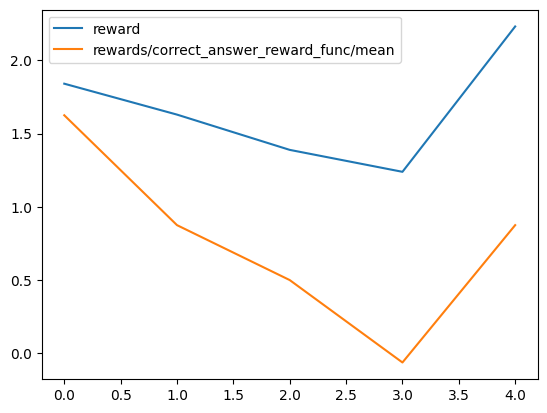

time: 345 ms (started: 2025-12-22 19:15:04 +00:00)


In [ ]:
# Show the total (sum) of the rewards as well as the correct_answer_reward_func (means with in the batch)
# No changes needed in this cell

import pandas as pd
import matplotlib.pyplot as plt

# If you want to graph other columns, check these out
print(f"available columns: {trainer.state.log_history[0].keys()}")

log_df = pd.DataFrame(trainer.state.log_history)
log_df["reward"].plot()
log_df["rewards/correct_answer_reward_func/mean"].plot()

# Show the legend
plt.legend(["reward", "rewards/correct_answer_reward_func/mean"])
plt.show()

### Slower train (1+ hour)

If everything looks good, let's go for a longer training session!

In [ ]:
# Now let's train for real! Let's do a longer training that will take an hour or more
# Note: If this run is successful, you can consider doing a longer train
# to see what happens, but that's beyond the scope of this project.

# Full training
training_args = GRPOConfig(
    **grpo_params,  # Use grpo_params, NOT COMMON_GRPO_TRAINING_PARAMS
    max_steps = 75,
)
trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=REWARD_FUNCS,
    args=training_args,
    train_dataset=ds,
)
trainer_res = trainer.train()


The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 401 | Num Epochs = 1 | Total steps = 75
O^O/ \_/ \    Batch size per device = 16 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (16 x 1 x 1) = 16
 "-____-"     Trainable parameters = 119,734,272 of 3,205,672,960 (3.74% trained)



--------------------
Question: How many of the letter "g" are there in the word "glisten"
Answer: 1
Response: <reasoning>
Counting the number of g's in the word glisten
1. g - 1 so far
2. l - 1 so far
3. i - 1 so far
4. s - 1 so far
5. t - 1 so far
6. e - 1 so far
7. n - 1 so far
</reasoning>
<answer>
1
</answer>
Extracted: 1
Correct: True!
    


Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,kl,rewards / numbering_reward_func / mean,rewards / numbering_reward_func / std,rewards / spelling_reward_func / mean,rewards / spelling_reward_func / std,rewards / counting_reward_func / mean,rewards / counting_reward_func / std,rewards / format_reward_func / mean,rewards / format_reward_func / std,rewards / correct_answer_reward_func / mean,rewards / correct_answer_reward_func / std
1,0.000000,1.856473,2.412027,91.125000,38.000000,174.000000,0.000000,91.125000,38.000000,174.000000,0.002850,0.373884,0.145223,-0.843750,2.256241,0.076339,0.760638,1.000000,0.000000,1.250000,1.341641
2,0.000000,0.177431,2.434868,93.687500,53.000000,196.000000,0.000000,93.687500,53.000000,196.000000,0.003972,0.440625,0.052738,-1.593750,3.023347,0.018056,0.608160,1.000000,0.000000,0.312500,1.537043
3,0.000000,0.630060,2.630259,86.687500,53.000000,140.000000,0.000000,86.687500,53.000000,140.000000,0.003895,0.422619,0.101552,-1.406250,2.245134,0.301190,0.664970,1.000000,0.000000,0.312500,1.537043
4,0.000000,1.401339,1.663686,80.625000,62.000000,113.000000,0.000000,80.625000,62.000000,113.000000,0.002672,0.463542,0.042696,-0.093750,1.908042,-0.280952,0.500715,1.000000,0.000000,0.312500,1.537043
5,0.000000,2.770461,1.737792,78.125000,56.000000,94.000000,0.000000,78.125000,56.000000,94.000000,0.002599,0.447545,0.133546,-0.031250,2.117142,0.104167,0.625236,1.000000,0.000000,1.250000,1.341641
6,0.000000,1.189435,1.327118,72.062500,26.000000,109.000000,0.000000,72.062500,26.000000,109.000000,0.003727,0.411161,0.136644,-0.750000,2.190890,0.215774,0.718215,1.000000,0.000000,0.312500,1.537043
7,0.000000,0.098958,2.164848,74.562500,39.000000,85.000000,0.000000,74.562500,39.000000,85.000000,0.004085,0.359375,0.088659,-1.875000,1.347838,0.302083,0.553971,1.000000,0.000000,0.312500,1.537043
8,0.000000,0.070933,0.817885,87.562500,71.000000,113.000000,0.000000,87.562500,71.000000,113.000000,0.002724,0.433036,0.062969,-1.500000,1.414214,0.200397,0.769710,1.000000,0.000000,-0.062500,1.436141
9,0.000000,-0.342560,2.648365,76.375000,38.000000,111.000000,0.000000,76.375000,38.000000,111.000000,0.003837,0.324405,0.170686,-2.125000,2.202272,0.145536,0.788193,1.000000,0.000000,0.312500,1.537043
10,0.000000,1.334747,2.203437,77.937500,62.000000,95.000000,0.000000,77.937500,62.000000,95.000000,0.002887,0.445759,0.058455,-0.312500,1.931105,-0.111012,0.487100,1.000000,0.000000,0.312500,1.537043



--------------------
Question: How many of the letter "e" are there in the word "sapphire"
Answer: 1
Response: <reasoning>
Counting the number of e's in the word sapphire
1. s - 0 so far
2. a - 1 so far
3. p - 1 so far
4. a - 2 so far
5. f - 2 so far
6. l - 2 so far
7. a - 3 so far
8. y - 3 so far
9. e - 4 so far
</reasoning>
<answer>
4
</answer>
Extracted: 4
Correct: False!
    

--------------------
Question: How many of the letter "x" are there in the word "absolve"
Answer: 0
Response: <reasoning>
Counting the number of x's in the word abslove
1. a - 0 so far
2. b - 1 so far
3. s - 1 so far
4. x - 1 so far
5. v - 2 so far
6. e - 3 so far
</reasoning>
<answer>
1
</answer>
Extracted: 1
Correct: False!
    

--------------------
Question: How many of the letter "g" are there in the word "mirage"
Answer: 1
Response: <reasoning>
Counting the number of g's in the word "mirage"
1. m - 0 so far
2. i - 0 so far
3. r - 0 so far
4. a - 0 so far
5. g - 1 so far
6. e - 1 so far
</reasoning>
<an

available columns: dict_keys(['loss', 'grad_norm', 'learning_rate', 'num_tokens', 'completions/mean_length', 'completions/min_length', 'completions/max_length', 'completions/clipped_ratio', 'completions/mean_terminated_length', 'completions/min_terminated_length', 'completions/max_terminated_length', 'rewards/numbering_reward_func/mean', 'rewards/numbering_reward_func/std', 'rewards/spelling_reward_func/mean', 'rewards/spelling_reward_func/std', 'rewards/counting_reward_func/mean', 'rewards/counting_reward_func/std', 'rewards/format_reward_func/mean', 'rewards/format_reward_func/std', 'rewards/correct_answer_reward_func/mean', 'rewards/correct_answer_reward_func/std', 'reward', 'reward_std', 'frac_reward_zero_std', 'completion_length', 'kl', 'epoch', 'step'])


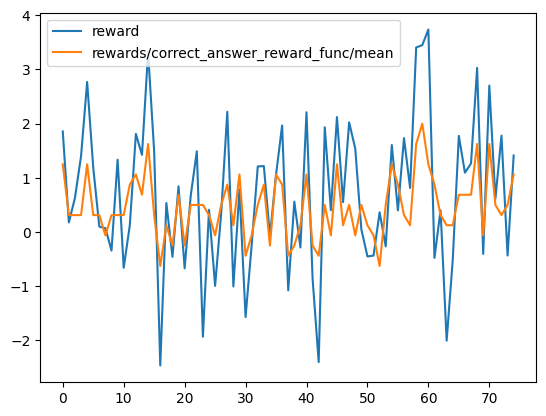

time: 159 ms (started: 2025-12-22 20:07:43 +00:00)


In [ ]:
# Show the total (sum) of the rewards as well as the correct_answer_reward_func (means with in the batch)
# Do you see the rewards increasing? Does the model get the correct answer
# more frequently toward the end?
# No changes needed in this cell

import pandas as pd
import matplotlib.pyplot as plt

# If you want to graph other columns, check these out
print(f"available columns: {trainer.state.log_history[0].keys()}")

log_df = pd.DataFrame(trainer.state.log_history)
log_df["reward"].plot()
log_df["rewards/correct_answer_reward_func/mean"].plot()

# Show the legend
plt.legend(["reward", "rewards/correct_answer_reward_func/mean"])
plt.show()

## View the results
Now let's try the model we just trained!

In [ ]:
# Save the LoRA adapters
# No changes needed in this cell

# Save the LoRA model
# model.save_lora("grpo_saved_lora")
model.save_pretrained("grpo_saved_lora")
tokenizer.save_pretrained("grpo_saved_lora")

('grpo_saved_lora/tokenizer_config.json',
 'grpo_saved_lora/special_tokens_map.json',
 'grpo_saved_lora/chat_template.jinja',
 'grpo_saved_lora/vocab.json',
 'grpo_saved_lora/merges.txt',
 'grpo_saved_lora/added_tokens.json',
 'grpo_saved_lora/tokenizer.json')

time: 41.3 s (started: 2025-12-22 20:09:29 +00:00)


In [ ]:
# Create a function to run both the original model and the updated model
# No changes needed in this cell

def compare_old_and_new_model(messages):
    # 1. Text vorbereiten
    text = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    inputs = tokenizer([text], return_tensors="pt").to("cuda")


    # ---  1: using new model - is current active
    output_new = model.generate(
        **inputs,
        max_new_tokens=1024,
        temperature=0.8,
        top_p=0.95,
        use_cache=True,
    )
    new_text = tokenizer.decode(output_new[0], skip_special_tokens=True).split("assistant")[-1].strip()

    # ---  2: using old model
    with model.disable_adapter():
        output_old = model.generate(
            **inputs,
            max_new_tokens=1024,
            temperature=0.8,
            top_p=0.95,
            use_cache=True,
        )
    old_text = tokenizer.decode(output_old[0], skip_special_tokens=True).split("assistant")[-1].strip()

    print("=== OLD (Base Model) ===")
    print(old_text)
    print("\n\n=== NEW (GRPO LoRA) ===")
    print(new_text)


time: 3.93 ms (started: 2025-12-22 20:14:50 +00:00)


### Compare the old and new models on the letter-counting task

In [ ]:
# Let's try spelling the first word from the dataset

# Load the first item from the dataset (index 0) and compare the old and new models
compare_old_and_new_model(ds[0]["prompt"])


=== OLD (Base Model) ===
<reasoning>
Counting the number of a's in the word idea
1. i - 0 so far
2. d - 1 so far
3. e - 2 so far
4. a - 3 so far
</reasoning>
<answer>
3
</answer>


=== NEW (GRPO LoRA) ===
<reasoning>
1. i - 1 so far
2. d - 1 so far
3. e - 1 so far
4. a - 1 so far
</reasoning>
<answer>
1
</answer>
time: 8.09 s (started: 2025-12-22 20:14:56 +00:00)


Our model is better at spelling and counter letters in words! Depending on your reward functions, the size of your model, and the amount of steps trained, results may vary.

For about an hour of training time, your model may not be perfect (or maybe it is), but it's definitely moving in the right direction!

### Make sure the model did not forget basic facts

In [ ]:
# Let's see if the model still remembers some of the facts from its original training

# Ask both the old and new models a question the model is likely to know,
# e.g. a well-known capital city
compare_old_and_new_model([
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "What is the capital of France?"}
])


=== OLD (Base Model) ===
The capital of France is Paris.


=== NEW (GRPO LoRA) ===
The capital of France is Paris.
time: 1.26 s (started: 2025-12-22 20:15:26 +00:00)


Great job! Congrats on completing the project! 🎉🤗